## 전처리

### 셋업

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests 
from tqdm import tqdm
import numpy as np
from urllib.request import urlopen
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import platform
path = "c:/Windows/Fonts/malgun.ttf"
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
from matplotlib.pyplot import figure

import plotly.express as px

key='Iuowj7UW8R3d8WxSA%2Fh2wTsszZ1EZT22V%2FB%2BRBhNPW4bMCrxh0l89LSAmPjeCo1G%2FLjJTbmUbi%2FAM%2BL8Ae3cYQ%3D%3D'
url= 'http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19GenAgeCaseInfJson?pageNo=1&numOfRows=10&startCreateDt=20200101&endCreateDt=20201231&serviceKey={}'.format(key)

page=requests.get(url)
soup=BeautifulSoup(page.content, "html.parser")

rows = soup.find_all('item')

rowList = []
nameList = []
columnList = []

rowsLen = len(rows)
for i in range(0, rowsLen):
    columns = rows[i].find_all()
    
    columnsLen = len(columns)
    for j in range(0, columnsLen):
        if i == 0:
            nameList.append(columns[j].name) 
        eachColumn = columns[j].text
        columnList.append(eachColumn)
    rowList.append(columnList)
    columnList = []
    
result = pd.DataFrame(rowList, columns=nameList)
result.to_excel("age_gender.xlsx")

Unknown system... sorry~~~~
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


### api 데이터 전처리

In [2]:
age_gen=pd.read_excel("/content/age_gender.xlsx")
age_gen.rename(columns={'confcase':'확진자', 'confcaserate':'확진률', 'createdt':'등록일시분초',
                          'criticalrate':'치명률', 'death':'사망자', 'deathrate':'사망률','gubun':'구분(성별, 연령별)',
                          'seq':'확진자 성별, 연령별 고유값', 'updatedt':'수정일시분초'}, inplace=True)
age_gen=age_gen.drop(columns=['Unnamed: 0', '수정일시분초'])
age_gen=age_gen[age_gen["구분(성별, 연령별)"] != '0-11']
age_gen["구분(성별, 연령별)"].value_counts()
age_gen.reset_index(inplace = True)
age_gen=age_gen.drop(columns=['index'])
age_gen['등록일시']=[eachAddress.split()[0] for eachAddress in age_gen['등록일시분초']]
age_gen=age_gen.drop(columns=['등록일시분초'])
age_gen['등록연도']=age_gen['등록일시'].str[:4]
age_gen['등록월']=age_gen['등록일시'].str[5:7]
age_gen['등록일']=age_gen['등록일시'].str[8:]
age_gen.rename(columns = {"구분(성별, 연령별)": "성별/연령"}, inplace = True)
age_gen.rename(columns = {"확진자 성별, 연령별 고유값": "고유값"}, inplace = True)
dailycases=[]
for i in range(2904):
  a=age_gen['확진자'][i]-age_gen['확진자'][i+11]
  dailycases.append(a)
for k in range(22):
  dailycases.append(0)
age_gen['일일확진자']=dailycases
age_gen=age_gen.drop(age_gen.index[2904:2926])
age_gen=age_gen[['등록일시','등록연도', '등록월', '등록일', '성별/연령', '확진자', '일일확진자', '확진률', '치명률', '사망자', '사망률', '고유값']]
gen=age_gen[age_gen["성별/연령"].str.contains('여성|남성')]
gen.reset_index(inplace = True)
gen=gen.drop(columns=['index'])
age=age_gen[age_gen["성별/연령"].str.contains('0-9|10-19|20-29|30-39|40-49|50-59|60-69|70-79|80 이상')]
age.reset_index(inplace = True)
age=age.drop(columns=['index'])
gen.rename(columns = {"성별/연령": "성별"}, inplace = True)
age.rename(columns = {"성별/연령": "연령"}, inplace = True)
age_reverse=age.sort_index(ascending=False)
age_reverse.replace("80 이상", "80-", inplace=True)
gen_reverse=gen.sort_index(ascending=False)

### 사회 데이터 전처리

In [3]:
fes_rate=pd.read_csv("/content/drive/MyDrive/Cayley/0122/2019년 상반기와 2020 상반기 연령별 여성 자살률 비교.csv", encoding="UTF-8")
eco_po=pd.read_csv("/content/drive/MyDrive/Cayley/0122/경제활동인구총괄.csv", encoding="UTF-8")
age_gen_eco=pd.read_csv("/content/drive/MyDrive/Cayley/0122/성별연령별_경제활동인구.csv", encoding="UTF-8")
gen_sc=pd.read_csv("/content/drive/MyDrive/Cayley/0122/성_월별_특정_사망원인_고의적_자해__사망자_수.csv", encoding="UTF-8")
age_sc=pd.read_csv("/content/drive/MyDrive/Cayley/0122/연령별 고의적 자해 발생 현황.csv", encoding="UTF-8")
age_sc=age_sc.drop(age_sc.index[0])
refined_agesc=age_sc[['연령','2019년 상반기','2020년 상반기','2019년 상반기 대비 증가율']]
age_dep=pd.read_csv("/content/drive/MyDrive/Cayley/0122/우울증 관련 연령별 진료 현황.csv", encoding="UTF-8")
age_dep=age_dep.drop(age_dep.index[0])
refined_agedep=age_dep[['연령','2019년 상반기','2020년 상반기','2019년 상반기 대비 증가율']]
fes_rate=fes_rate.T
fes_rate=fes_rate.drop(fes_rate.index[0])
fes_rate.rename(columns = {0: "2019년"}, inplace = True)
fes_rate.rename(columns = {1: "2020년"}, inplace = True)
fes_rate.rename(columns = {2: "증감률"}, inplace = True)
for i in range(7):
  fes_rate['증감률'][i] = fes_rate['증감률'][i][:-4]
fes_rate=fes_rate.astype('int64')
fes_rate.reset_index(inplace=True)
fes_rate.rename(columns = {'index': "연령"}, inplace = True)

## 시각화

### api 시각화

In [4]:
fig_agec = px.pie(age_reverse, values='일일확진자', names='연령', title='연령별 확진자', color_discrete_sequence=px.colors.sequential.RdBu, width=600, height=400)
fig_aged = px.pie(age_reverse, values='사망자', names='연령', title='연령별 사망자', color_discrete_sequence=px.colors.sequential.RdBu, width=600, height=400)
fig_agec.show()
fig_aged.show()

In [5]:
figdc = px.violin(gen_reverse, y="사망률", color="성별", box=True,  points="all", title="성별 사망률", width=600, height=400)
figc = px.violin(gen_reverse, y="확진률", color="성별", box=True, points="all", title="성별 확진률", width=600, height=400)
figc.show()
figdc.show()

### 소셜 데이터 시각화

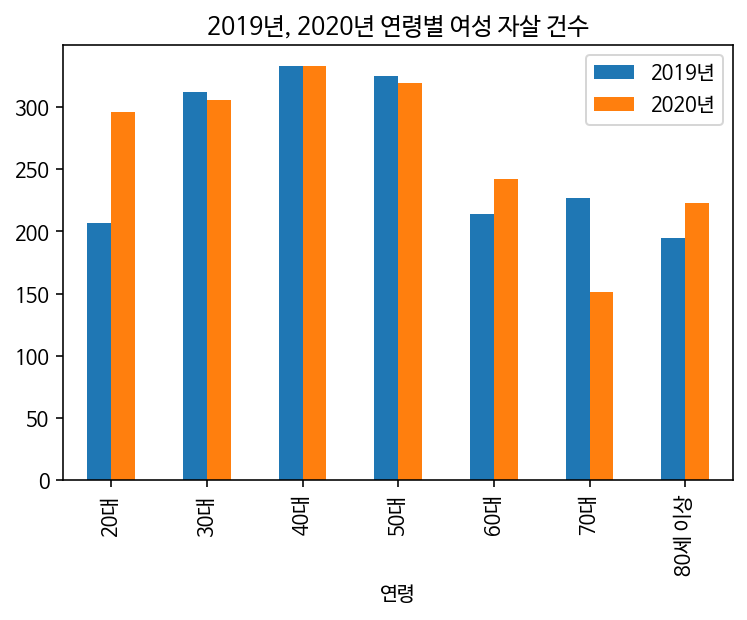

In [6]:
fes_rate.plot(x="연령", y=["2019년", "2020년"], kind="bar")
plt.title('2019년, 2020년 연령별 여성 자살 건수')
plt.show()

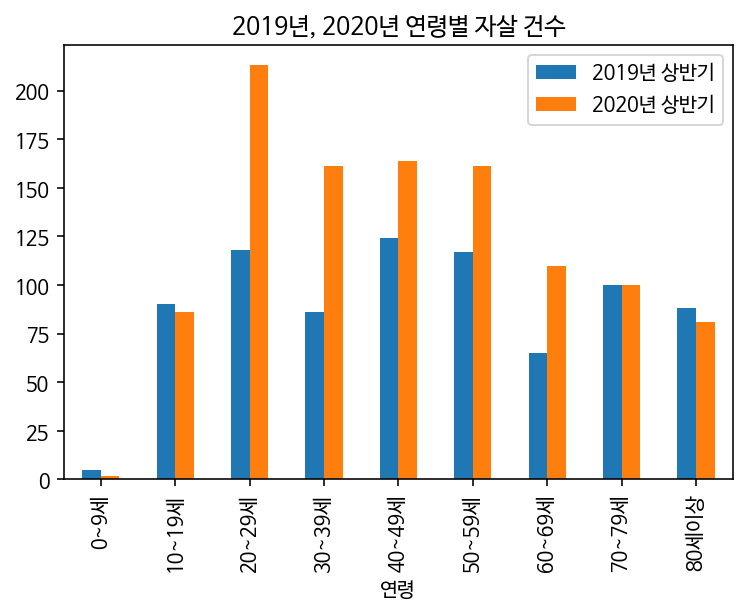

In [7]:
refined_agesc.plot(x="연령", y=["2019년 상반기", "2020년 상반기"], kind="bar")
plt.title('2019년, 2020년 연령별 자살 건수')
plt.show()

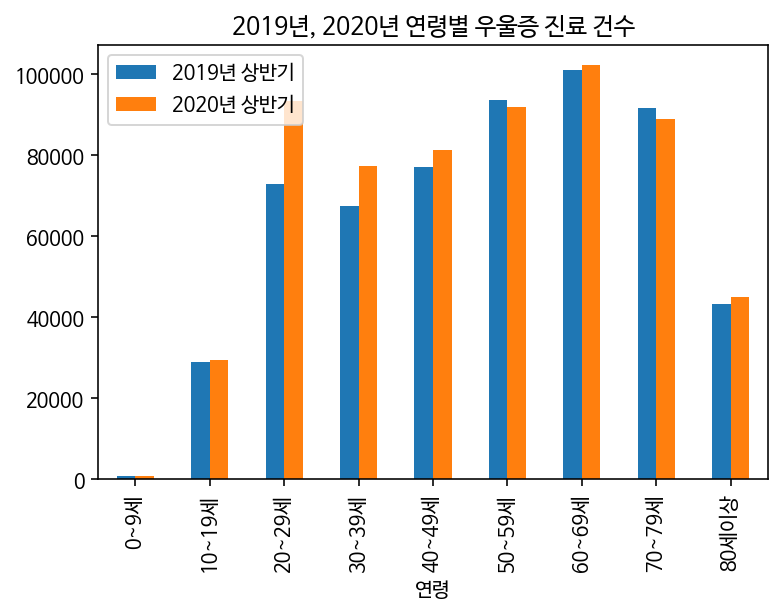

In [8]:
refined_agedep.plot(x="연령", y=["2019년 상반기", "2020년 상반기"], kind="bar")
plt.title('2019년, 2020년 연령별 우울증 진료 건수')
plt.show()